Customers Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID

<ipython-input-3-9d5f31d73f8e>:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette='viridis')


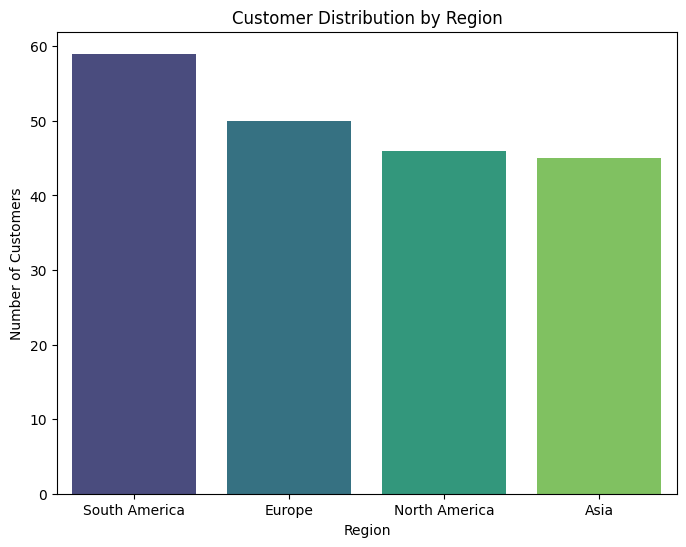

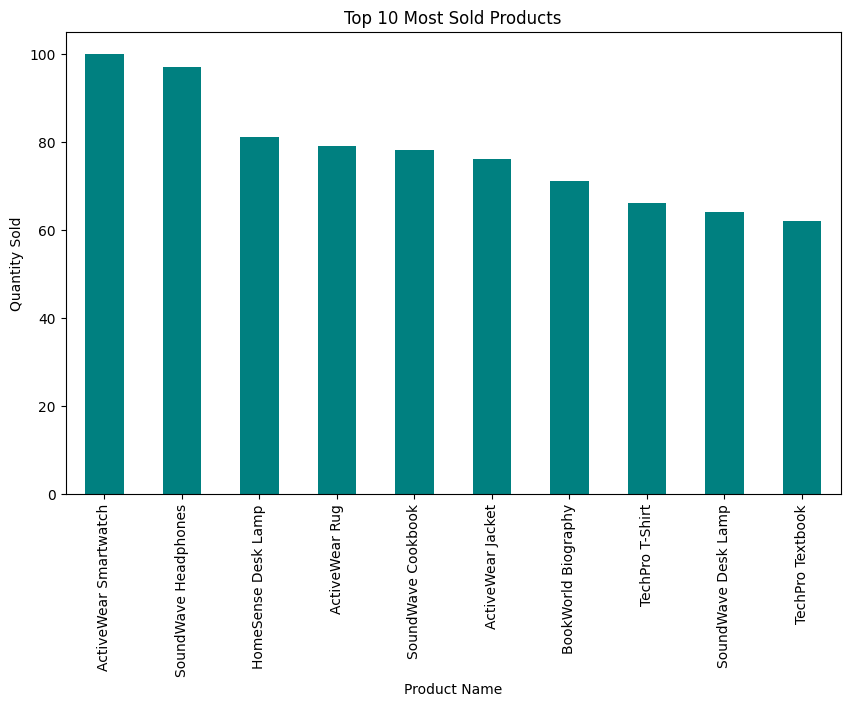

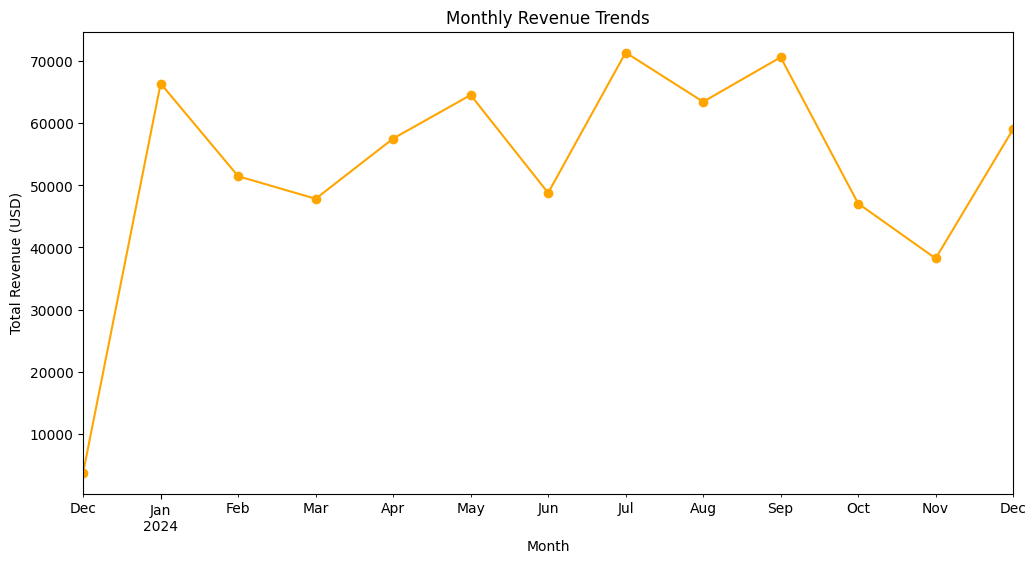

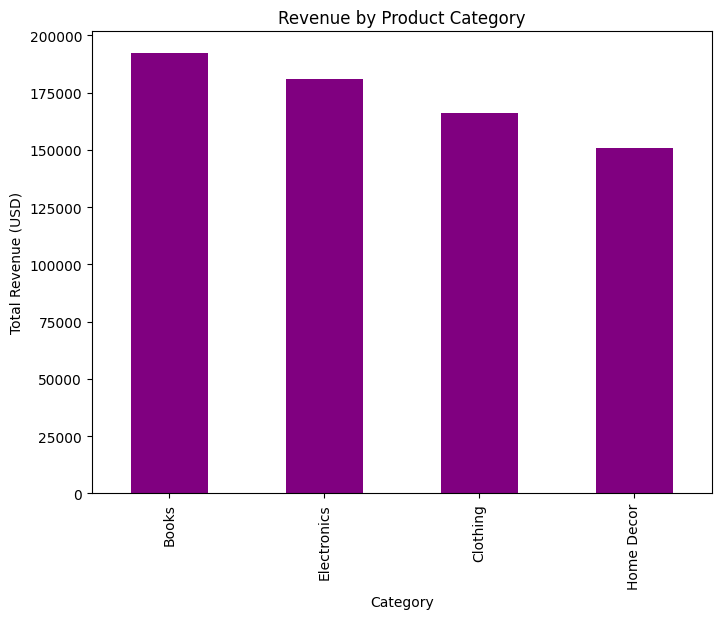

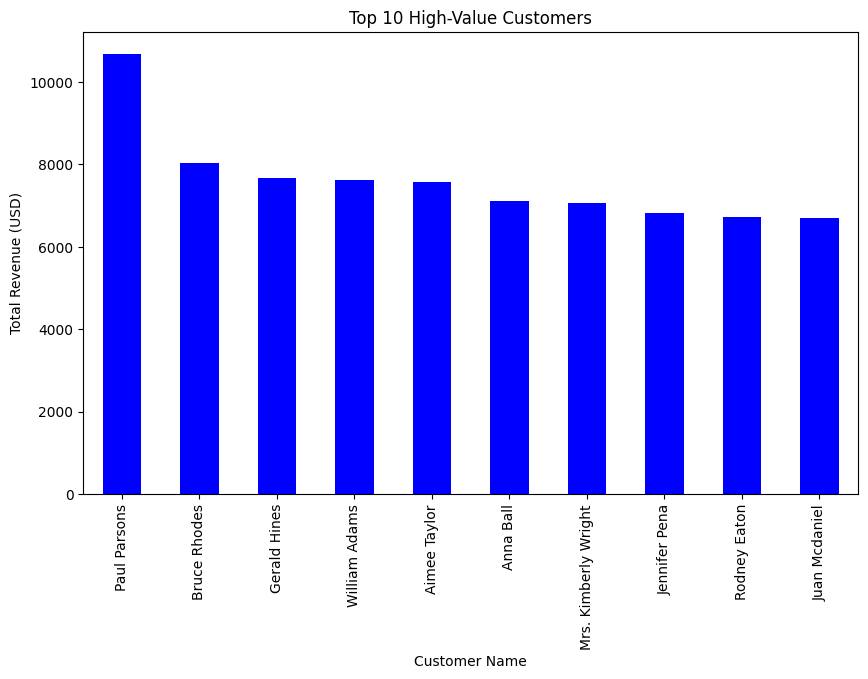

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Task 1: Exploratory Data Analysis (EDA)
# Load datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

# Display basic information about each dataset
print("Customers Dataset:")
print(customers.info())
print(customers.head())

print("\nProducts Dataset:")
print(products.info())
print(products.head())

print("\nTransactions Dataset:")
print(transactions.info())
print(transactions.head())

# Data Cleaning
# Check for missing values
print("\nMissing Values:")
print("Customers:")
print(customers.isnull().sum())
print("Products:")
print(products.isnull().sum())
print("Transactions:")
print(transactions.isnull().sum())

# Convert dates to datetime format
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Drop duplicates
customers.drop_duplicates(inplace=True)
products.drop_duplicates(inplace=True)
transactions.drop_duplicates(inplace=True)

# Merge datasets for analysis
merged_data = transactions.merge(products, on='ProductID').merge(customers, on='CustomerID')
print("\nMerged Data:")
print(merged_data.head())

# Exploratory Data Analysis (EDA)
# 1. Customer distribution by region
region_counts = customers['Region'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=region_counts.index, y=region_counts.values, palette='viridis')
plt.title("Customer Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Number of Customers")
plt.show()

# 2. Top 10 most sold products
top_products = merged_data.groupby('ProductName')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_products.plot(kind='bar', color='teal')
plt.title("Top 10 Most Sold Products")
plt.xlabel("Product Name")
plt.ylabel("Quantity Sold")
plt.show()

# 3. Revenue trends over time
merged_data['Month'] = merged_data['TransactionDate'].dt.to_period('M')
monthly_revenue = merged_data.groupby('Month')['TotalValue'].sum()
plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='line', marker='o', color='orange')
plt.title("Monthly Revenue Trends")
plt.xlabel("Month")
plt.ylabel("Total Revenue (USD)")
plt.show()

# 4. Most profitable product categories
category_revenue = merged_data.groupby('Category')['TotalValue'].sum().sort_values(ascending=False)
plt.figure(figsize=(8, 6))
category_revenue.plot(kind='bar', color='purple')
plt.title("Revenue by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Revenue (USD)")
plt.show()

# 5. High-value customers
customer_revenue = merged_data.groupby('CustomerName')['TotalValue'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
customer_revenue.plot(kind='bar', color='blue')
plt.title("Top 10 High-Value Customers")
plt.xlabel("Customer Name")
plt.ylabel("Total Revenue (USD)")
plt.show()

# Save processed data for insights report
merged_data.to_csv("Processed_Data.csv", index=False)

In [5]:
# Merge all datasets
merged_data = transactions.merge(products, on='ProductID', how='left').merge(customers, on='CustomerID', how='left')

# Check column names to identify duplicates
print(merged_data.columns)

# Rename columns to avoid conflicts (if needed)
merged_data.rename(columns={'Price_x': 'TransactionPrice', 'Price_y': 'ProductPrice'}, inplace=True)

# Feature Engineering
# Aggregate transaction data for each customer
customer_features = merged_data.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'TransactionPrice': 'mean'  # Use the correct Price column name
}).reset_index()

# Merge with customer profile information
customer_profile = customers.merge(customer_features, on='CustomerID', how='left')
customer_profile.fillna(0, inplace=True)

# Normalize numerical features
scaler = StandardScaler()
numeric_features = ['Quantity', 'TotalValue', 'TransactionPrice']
customer_profile_scaled = customer_profile.copy()
customer_profile_scaled[numeric_features] = scaler.fit_transform(customer_profile_scaled[numeric_features])

# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(customer_profile_scaled[numeric_features])

# Get top 3 similar customers for each customer
def get_top_similar_customers(customer_id, similarity_matrix, customer_ids, top_n=3):
    customer_idx = customer_ids.index(customer_id)
    similarity_scores = list(enumerate(similarity_matrix[customer_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_customers = [(customer_ids[i[0]], i[1]) for i in similarity_scores[1:top_n+1]]
    return top_customers

# Create lookalike recommendations for first 20 customers
customer_ids = customer_profile['CustomerID'].tolist()
lookalike_recommendations = {}

for customer_id in customer_ids[:20]:
    lookalike_recommendations[customer_id] = get_top_similar_customers(customer_id, similarity_matrix, customer_ids)

# Save recommendations to CSV
lookalike_df = pd.DataFrame({
    'CustomerID': customer_ids[:20],
    'SimilarCustomers': [str(lookalike_recommendations[cust_id]) for cust_id in customer_ids[:20]]
})

lookalike_df.to_csv("FirstName_LastName_Lookalike.csv", index=False)

print("Lookalike recommendations generated and saved to FirstName_LastName_Lookalike.csv")


Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price_x', 'ProductName', 'Category',
       'Price_y', 'CustomerName', 'Region', 'SignupDate'],
      dtype='object')
Lookalike recommendations generated and saved to FirstName_LastName_Lookalike.csv


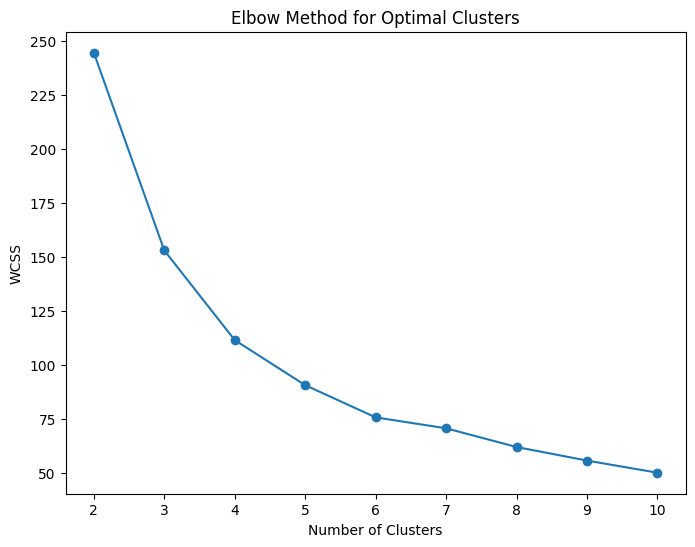

Davies-Bouldin Index: 0.8052437830269734


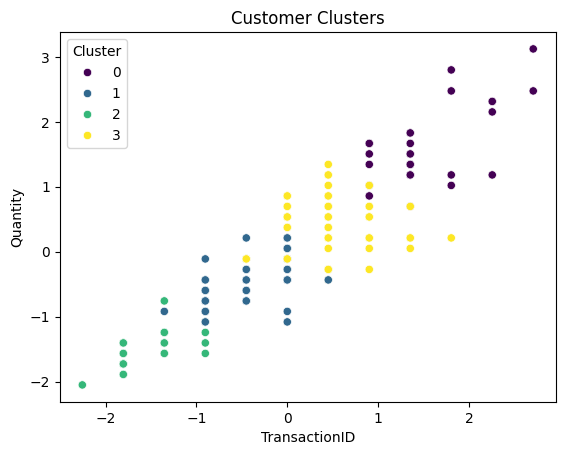

Clustering completed and results saved to FirstName_LastName_Clustering.csv.


In [6]:
# Task 3: Customer Segmentation
# Aggregate transaction data for each customer
customer_transactions = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Number of transactions
    'Quantity': 'sum',        # Total quantity purchased
    'TotalValue': 'sum'       # Total value of purchases
}).reset_index()

# Merge with customer profile information
customer_data = customers.merge(customer_transactions, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)

# Select features for clustering
features = ['TransactionID', 'Quantity', 'TotalValue']
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

# Determine optimal number of clusters using the Elbow Method
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(customer_data_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Fit K-Means with optimal clusters (choose based on the elbow graph)
optimal_clusters = 4  # Example value; replace with your choice from the elbow graph
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(customer_data_scaled, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Visualize clusters using scatter plot (for first two features)
sns.scatterplot(
    x=customer_data_scaled[:, 0],
    y=customer_data_scaled[:, 1],
    hue=customer_data['Cluster'],
    palette='viridis'
)
plt.title('Customer Clusters')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(title='Cluster')
plt.show()

# Save clustering results
customer_data.to_csv("FirstName_LastName_Clustering.csv", index=False)

print("Clustering completed and results saved to FirstName_LastName_Clustering.csv.")
